In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from math import isclose

C:\Users\BEJ5KOR\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
msft = pd.read_csv('msft.csv')
msft = msft.drop(['Volume', 'Open', 'High', 'Low'], axis=1)
msft.rename(columns={"Close": "stockValue"}, inplace=True)

In [7]:
msft.head()

,Date,stockValue
0,30-Dec-16,62.14


### Module 1 
Buidling the simple function to detect change in trendline of data

In [9]:
def extTrend(df, colName, colDate, freq, show = False):
    from statsmodels.tsa.seasonal import seasonal_decompose
    """ Detects the change in extracted trend
    
        df: takes a DataFrame which contains extracted trend TimeStamp as index
        
        colName: colname is the name of column, contain Values
        
        colDate: colname of Date Column
        
        freq: freq of the DataSet takes int value e.g. 30 for monthly freq
        
        Returns: DataFrame concatenated with Trend and Displays image if set show = True
    """
    df[colDate] = pd.to_datetime(df[colDate])
    
    df = df.set_index(colDate)
    df = df.sort_index()
    
    trend = pd.DataFrame(seasonal_decompose(df[colName],freq=freq).trend)
    
    trend.rename(columns={colName: 'Trend'}, inplace=True)
    
    df = pd.concat([df, trend], axis=1)
    """Plot the DataFrame
    """
    if show:
        df.plot(legend = True)
        plt.show()
#         fig = fig.get_figure()
#         fig.savefig('test.jpg')
    return df

In [10]:
def rolling_window(ts, window, step):
    """
    ts: Takes df/Series
    window: takes Int value of length of window user wants 
    stride: Step Size of sliding window
    """
    shape = ts.shape[:-1] + (int((ts.shape[-1] - window)/step + 1), window)
    strides = (step*ts.strides[-1],) + (ts.strides[-1],)
    array = np.lib.stride_tricks.as_strided(ts, shape=shape,strides=strides)
    stack = array[-(window-1):]
    array = np.append(array, stack, axis=0)
    return array

In [11]:
def getSlope(arr):
    slope = []
    l, n = arr.shape
    for i in range(l):
        try:
            slope.append(arr[i,n-1] - arr[i,0])/(n-1)
        except TypeError:
            pass
    return slope

In [12]:
def detectChange(df, colname):
    """  
    Detects the change in extracted slope values of windowed trend 
    
    df: takes a DataFrame which contains extracted trend TimeStamp as index 
    
    colName: colname is the name of column, contain Values
    
    Returns: DataFrame with a Binary coded column "detectedChange",
    
    0 represent No_Change and 1 means change_detected.
    """
    a = np.array(df[colname])
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    df['changeDetected'] = signchange
    return df

In [13]:
def scale(df, x):
    
    df['Normalized {}'.format(x)] = (df[x] - df[x].mean()) / (df[x].max() - df[x].min())

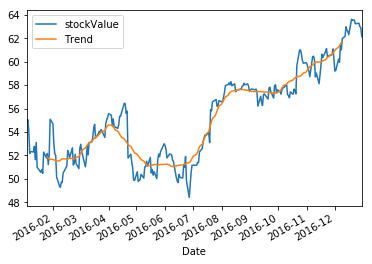

C:\Users\BEJ5KOR\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,stockValue,Trend,slope,changeDetected
Date,,,,
2016-01-26,52.17,51.873000,-0.212500,1
2016-01-27,51.22,51.785667,-0.160000,0
2016-01-28,52.06,51.700833,-0.102167,0
2016-01-29,55.09,51.671667,-0.090000,0
2016-02-01,54.71,51.660500,-0.121667,0


In [31]:
a = extTrend(msft, colName='stockValue', colDate='Date', freq=30, show = True)
rolled_array = rolling_window(a['Trend'], 5, 1)
rolled_array.shape
a['slope'] = getSlope(rolled_array)
aDrop = a.dropna()
aDrop = detectChange(aDrop, colname='slope')
aDrop.head()

In [32]:
scale(aDrop, x='stockValue')
scale(aDrop, x='Trend')

C:\Users\BEJ5KOR\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
# sum(aDrop['changeDetected'])
aDrop.drop(['stockValue', 'Trend'], 1, inplace=True)

C:\Users\BEJ5KOR\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


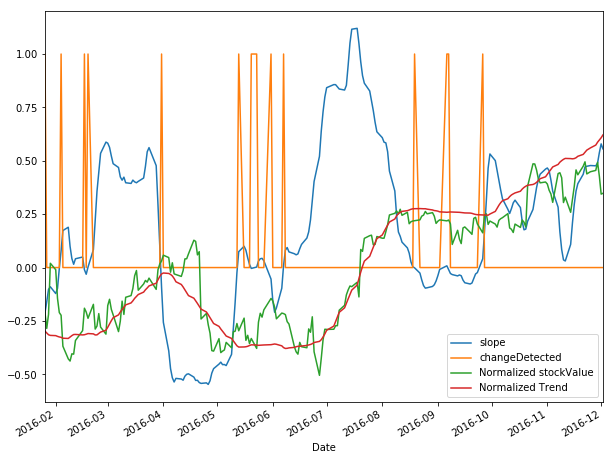

In [34]:
aDrop.plot(legend = True, figsize=(10,8))
plt.show()